In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import loadmat
from scipy.optimize import minimize
from scipy.optimize import linprog
import pywt

## s0017lrem signal

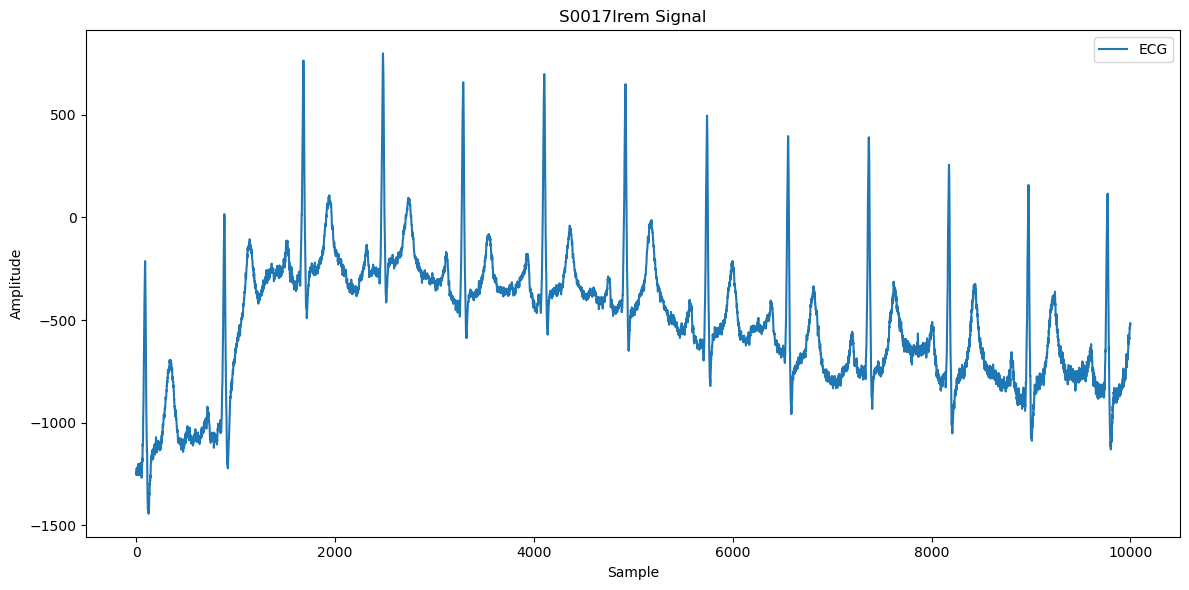

In [3]:
mat_data = loadmat('s0017lrem.mat')
ecg_signal = mat_data['val'][0].squeeze()
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label='ECG')
plt.title('S0017lrem Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

## 08378m Signal

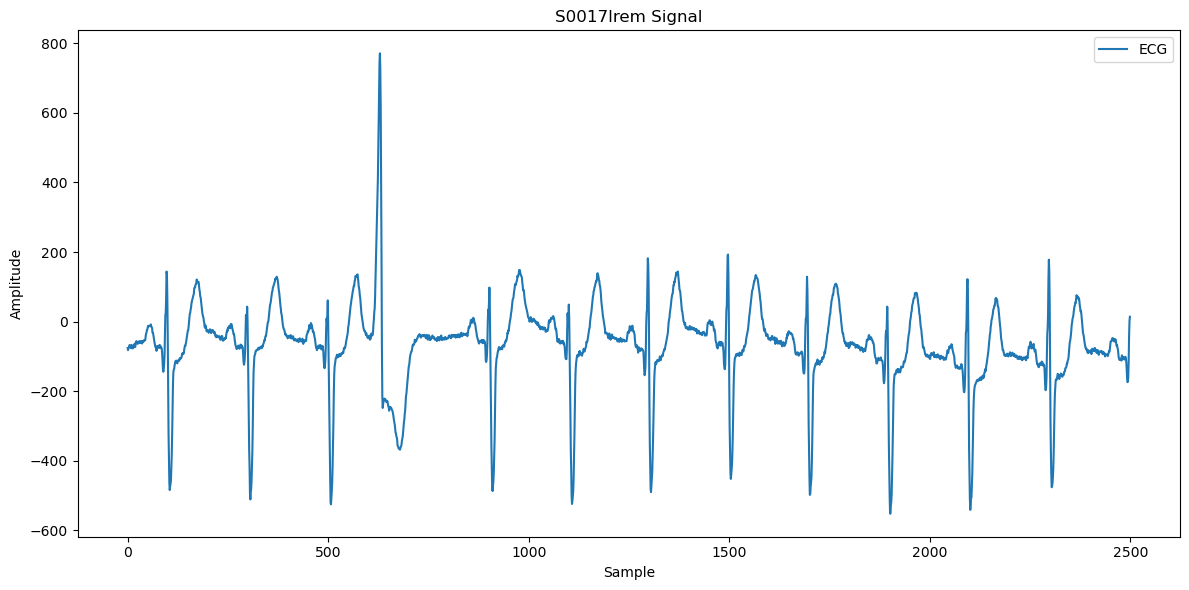

In [104]:
mat_data = loadmat('08378m.mat')
ecg_signal = mat_data['val'][0].squeeze()
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label='ECG')
plt.title('S0017lrem Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

# L2

This program compares Fourier transform for ECG signals.
Choose 1 for s0017lrem.mat or 2 for 08378m.mat


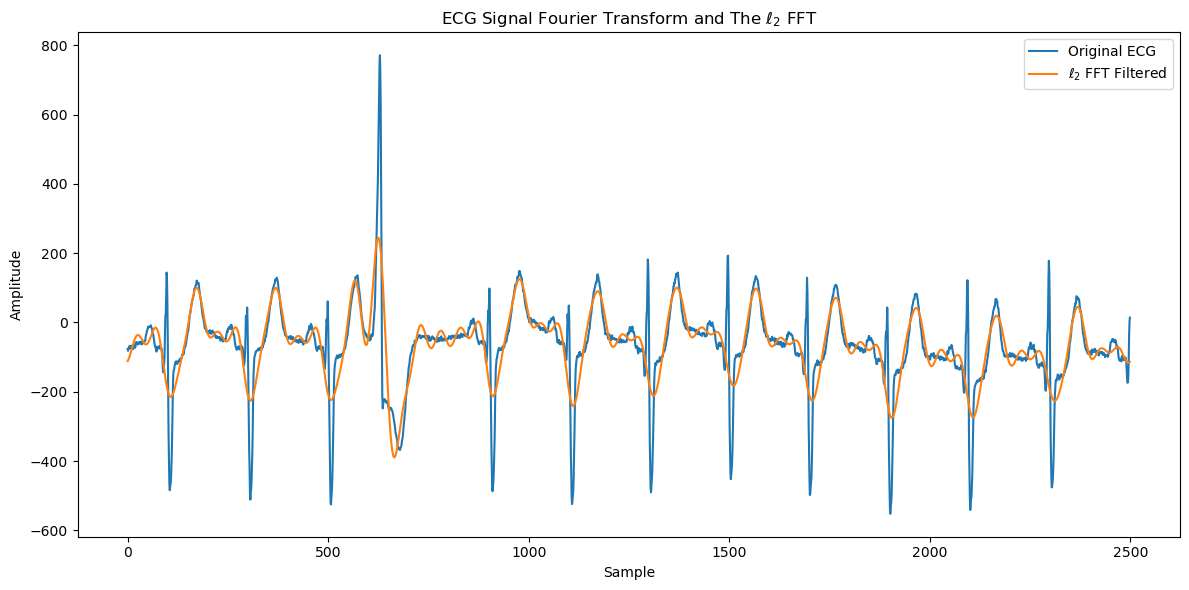

In [59]:
def Fourier_basis_function(x, M):
    """
    Create Fourier basis functions
    
    Parameters:
    x : array of indices
    M : number of frequency components to include
    
    Returns:
    Phi : Fourier basis matrix
    """
    L = len(x)
    Phi = np.zeros((2 * M + 1, L))
    Phi[0, :] = 1 / L

    m = 1  # Indexing starts at 1
    for k in range(1, M + 1):
        Phi[m, :] = (1 / L) * np.cos(k * 2 * np.pi * x / L)
        Phi[m + 1, :] = (1 / L) * np.sin(k * 2 * np.pi * x / L)
        m += 2
        #print(type(Phi))
        #print(Phi.shape)
        #print(Phi)
    return Phi

def main():
    # Choose ECG signal
    print('This program compares Fourier transform for ECG signals.')
    print('Choose 1 for s0017lrem.mat or 2 for 08378m.mat')
    choose = input()

    # Load the appropriate ECG signal
    if choose == '1':
        mat_data = loadmat('s0017lrem.mat')
        fs = 1000
        cutoff = 8.5   #8.5
        ecg_signal = mat_data['val'][0].squeeze()
    else:
        mat_data = loadmat('08378m.mat')
        fs = 250
        cutoff = 5              #5
        ecg_signal = mat_data['val'][0].squeeze()

    # Compute signal length and M (truncation point)
    N = len(ecg_signal)
    M = round(cutoff * N / fs)
    # Create indices
    x = np.arange(N)
    # Compute Fourier basis functions
    Phi = Fourier_basis_function(x, M)

    # Compute coefficients using the l2 norm method
    C = np.linalg.inv(Phi @ Phi.T) @ Phi @ ecg_signal

    # Reconstruct the filtered signal
    filteredL2fft_signal = C.T @ Phi

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(ecg_signal, label='Original ECG')
    plt.plot(filteredL2fft_signal, label='$\ell_2$ FFT Filtered')
    plt.title('ECG Signal Fourier Transform and The $\ell_2$ FFT')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Run the main function
if __name__ == '__main__':
    main()

# L1

This program compares pure L1 Fourier transform for ECG signals.
Choose 1 for s0017lrem.mat or 2 for 08378m.mat


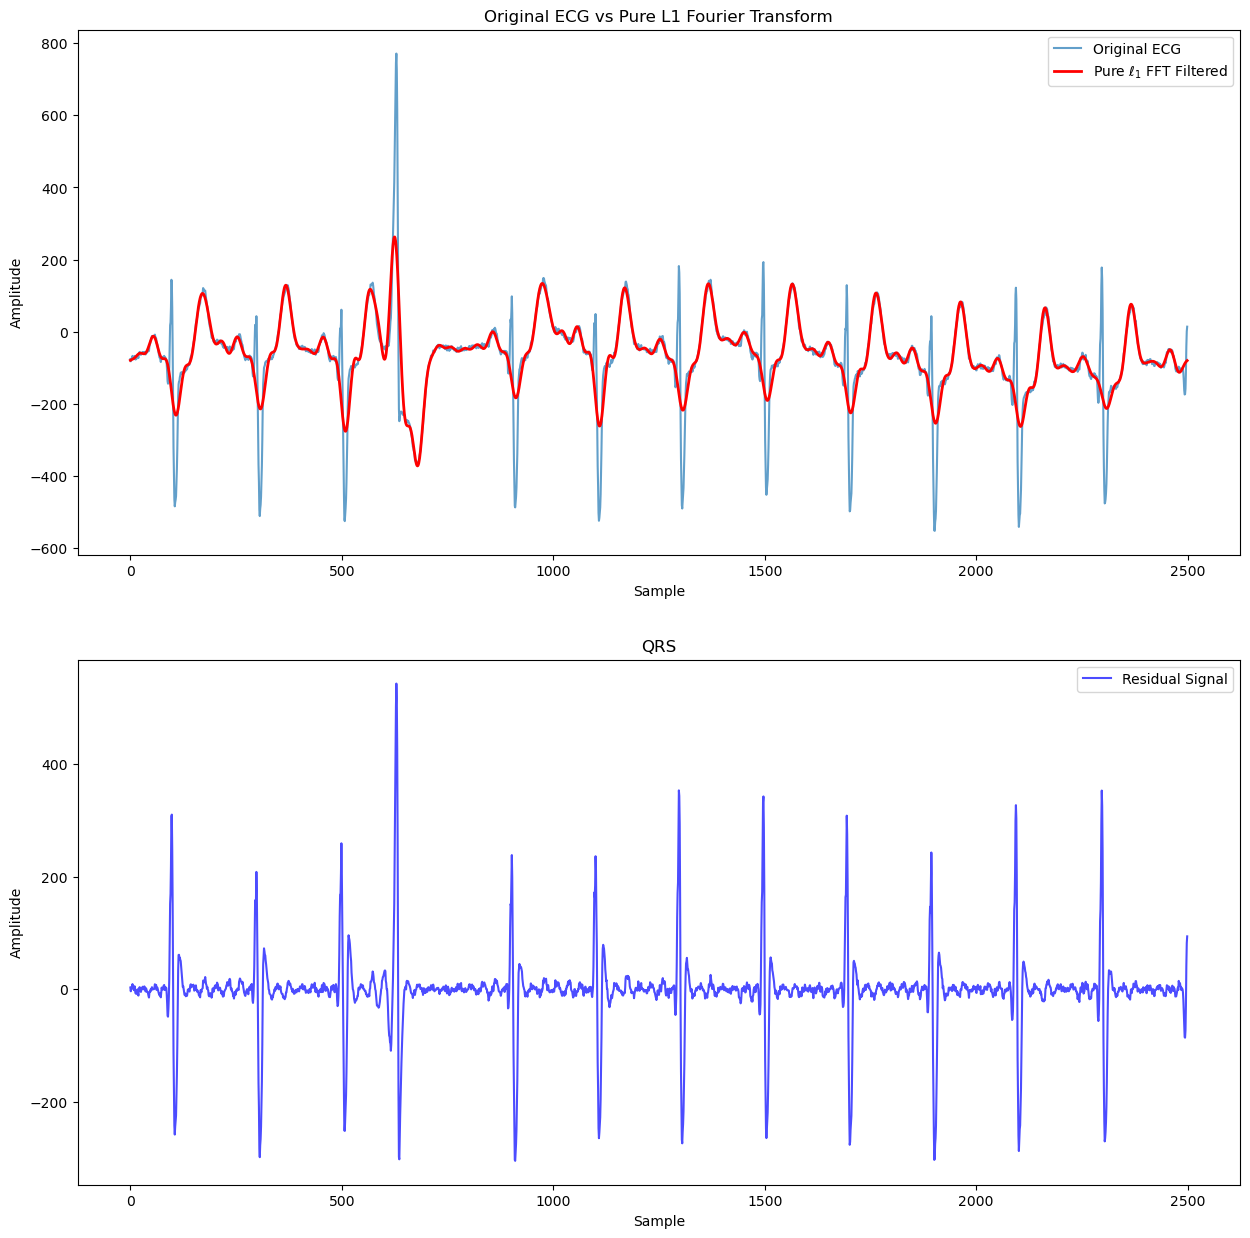

In [63]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, fs, lowcut, highcut):
    """
    Apply a bandpass filter to a signal.

    Parameters:
    signal : array-like
        Input signal to be filtered.
    fs : float
        Sampling frequency of the signal.
    lowcut : float
        Lower cutoff frequency of the bandpass filter.
    highcut : float
        Upper cutoff frequency of the bandpass filter.

    Returns:
    filtered_signal : array-like
        Filtered version of the input signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, signal)

def fourier_basis_function(x, M):
    """
    Create Fourier basis functions.
    
    Parameters:
    x : array of indices
    M : number of frequency components
    
    Returns:
    Phi : Fourier basis matrix (2M + 1) × N
    """
    L = len(x)
    Phi = np.zeros((2 * M + 1, L))
    Phi[0, :] = 1 / L

    m = 1
    for k in range(1, M + 1):
        Phi[m, :] = (1 / L) * np.cos(k * 2 * np.pi * x / L)
        Phi[m + 1, :] = (1 / L) * np.sin(k * 2 * np.pi * x / L)
        m += 2
    return Phi

def l1_objective(coeffs, Phi, signal):
    """
    Pure L1 objective function: ||x - Φc||₁
    
    Parameters:
    coeffs : Fourier coefficients
    Phi : Fourier basis matrix
    signal : Input signal
    
    Returns:
    L1 norm of the reconstruction error
    """
    reconstruction = coeffs @ Phi
    return np.sum(np.abs(signal - reconstruction))

def pure_l1_fourier_transform(signal, Phi):
    """
    Compute pure L1 Fourier transform by directly minimizing ||x - Φc||₁
    
    Parameters:
    signal : Input signal
    Phi : Fourier basis matrix
    
    Returns:
    coeffs : Optimal Fourier coefficients
    filtered_signal : Reconstructed signal
    """
    # Get initial guess using L2 solution for faster convergence
    initial_coeffs = np.linalg.inv(Phi @ Phi.T) @ Phi @ signal
    
    # Minimize L1 norm directly
    result = minimize(
        l1_objective,
        initial_coeffs,
        args=(Phi, signal),
        method='Powell',  # Powell method works well for non-smooth L1 norm
        options={'maxiter': 2000, 'ftol': 1e-6}
    )
    
    if not result.success:
        raise ValueError(f"L1 optimization failed: {result.message}")
    
    coeffs = result.x
    filtered_signal = coeffs @ Phi
    
    return coeffs, filtered_signal

def main():
    print('This program compares pure L1 Fourier transform for ECG signals.')
    print('Choose 1 for s0017lrem.mat or 2 for 08378m.mat')
    choose = input()

    # Load and prepare ECG signal
    if choose == '1':
        mat_data = loadmat('s0017lrem.mat')
        fs = 1000
        cutoff = 8.5
        ecg_signal = mat_data['val'][0].squeeze()
    else:
        mat_data = loadmat('08378m.mat')
        fs = 250
        cutoff = 8
        ecg_signal = mat_data['val'][0].squeeze()

    # Compute parameters and basis functions
    N = len(ecg_signal)
    M = round(cutoff * N / fs)
    x = np.arange(N)
    Phi = fourier_basis_function(x, M)

    # Perform pure L1 Fourier Transform
    coeffs, filtered_signal = pure_l1_fourier_transform(ecg_signal, Phi)

    # Compute the residual signal
    residual_signal = ecg_signal - filtered_signal

    # Apply bandpass filtering to the residual signal
    filtered_residual_signal = bandpass_filter(residual_signal, fs, 0.5, 40)

    # Plotting
    plt.figure(figsize=(15, 15))

    # Plot original and reconstructed signal
    plt.subplot(2, 1, 1)
    plt.plot(ecg_signal, label='Original ECG', alpha=0.7)
    plt.plot(filtered_signal, label='Pure $\ell_1$ FFT Filtered', color='red', linewidth=2)
    plt.title('Original ECG vs Pure L1 Fourier Transform')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()

    # Plot residual signal
    plt.subplot(2, 1, 2)
    plt.plot(residual_signal, label='Residual Signal', color='blue', alpha=0.7)
    plt.title('QRS')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()


if __name__ == '__main__':
    main()



## showing original signal and L1 and L2

This program compares L1 and L2 Fourier transforms for ECG signals.
Choose 1 for s0017lrem.mat, 2 for 08378m.mat, or 3 for 08434_4s_segment.mat


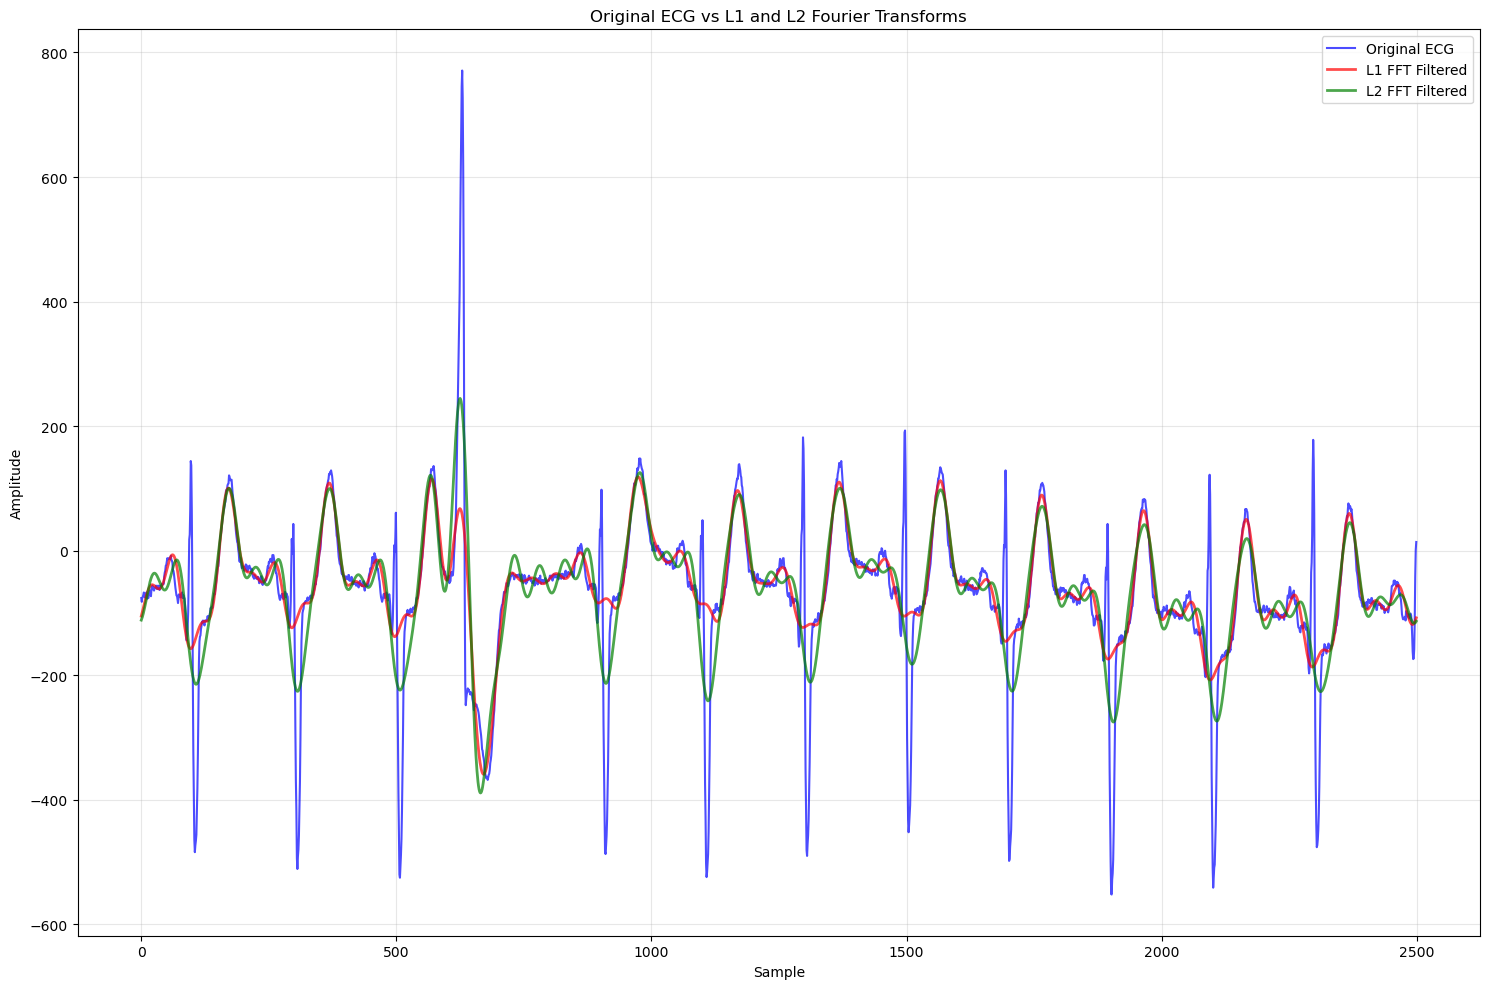

In [65]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
import matplotlib.pyplot as plt

def fourier_basis_function(x, M):
    """
    Create Fourier basis functions.
    
    Parameters:
    x : array of indices
    M : number of frequency components
    
    Returns:
    Phi : Fourier basis matrix (2M + 1) × N
    """
    L = len(x)
    Phi = np.zeros((2 * M + 1, L))
    Phi[0, :] = 1 / L

    m = 1
    for k in range(1, M + 1):
        Phi[m, :] = (1 / L) * np.cos(k * 2 * np.pi * x / L)
        Phi[m + 1, :] = (1 / L) * np.sin(k * 2 * np.pi * x / L)
        m += 2
    return Phi

def l1_objective(coeffs, Phi, signal):
    """
    Pure L1 objective function: ||x - Φc||₁
    """
    reconstruction = coeffs @ Phi
    return np.sum(np.abs(signal - reconstruction))

def pure_l1_fourier_transform(signal, Phi):
    """
    Compute pure L1 Fourier transform by directly minimizing ||x - Φc||₁
    """
    initial_coeffs = np.linalg.inv(Phi @ Phi.T) @ Phi @ signal
    
    result = minimize(
        l1_objective,
        initial_coeffs,
        args=(Phi, signal),
        method='Powell',
        options={'maxiter': 2000, 'ftol': 1e-10}
    )
    
    if not result.success:
        raise ValueError(f"L1 optimization failed: {result.message}")
    
    coeffs = result.x
    filtered_signal = coeffs @ Phi
    return coeffs, filtered_signal

def l2_fourier_transform(signal, Phi):
    """
    Compute L2 Fourier transform using the normal equation.
    """
    coeffs = np.linalg.inv(Phi @ Phi.T) @ Phi @ signal
    filtered_signal = coeffs @ Phi
    return coeffs, filtered_signal

def main():
    print('This program compares L1 and L2 Fourier transforms for ECG signals.')
    print('Choose 1 for s0017lrem.mat, 2 for 08378m.mat, or 3 for 08434_4s_segment.mat')
    choose = input()

    # Load and prepare ECG signal
    if choose == '1':
        mat_data = loadmat('s0017lrem.mat')
        fs = 1000
        cutoff = 8.5
        ecg_signal = mat_data['val'][0].squeeze()
    elif choose == '2':
        mat_data = loadmat('08378m.mat')
        fs = 250
        cutoff = 5
        ecg_signal = mat_data['val'][0].squeeze()
    elif choose == '3':
        mat_data = loadmat('100_4s_segment.mat')
        fs = 250
        cutoff = 6
        
        # Handle the two-channel case
        print("\nDetected two ECG channels in the data.")
        print("Choose channel to analyze:")
        print("1: ECG1")
        print("2: ECG2")
        channel_choice = input()
        
        if channel_choice == '1':
            ecg_signal = mat_data['signal'][:, 0]  # Select first channel
            channel_name = "ECG1"
        elif channel_choice == '2':
            ecg_signal = mat_data['signal'][:, 1]  # Select second channel
            channel_name = "ECG2"
        else:
            print("Invalid channel choice. Exiting.")
            return
            
        print(f"\nAnalyzing {channel_name} channel...")
    else:
        print("Invalid choice. Exiting.")
        return


    # Compute parameters and basis functions
    N = len(ecg_signal)
    M = round(cutoff * N / fs)
    x = np.arange(N)
    Phi = fourier_basis_function(x, M)

    # Perform L1 and L2 Fourier Transforms
    l1_coeffs, l1_filtered = pure_l1_fourier_transform(ecg_signal, Phi)
    l2_coeffs, l2_filtered = l2_fourier_transform(ecg_signal, Phi)

    # Plotting
    plt.figure(figsize=(15, 10))
    plt.plot(ecg_signal, label='Original ECG', alpha=0.7, color='blue')
    plt.plot(l1_filtered, label='L1 FFT Filtered', color='red', linewidth=2, alpha=0.7)
    plt.plot(l2_filtered, label='L2 FFT Filtered', color='green', linewidth=2, alpha=0.7)
    plt.title('Original ECG vs L1 and L2 Fourier Transforms')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

# wavelet + butterworth PQRST Locating

### s0017lrem

[  90  888 1683 2483 3289 4105 4921 5741 6557 7369 8175 8974 9769]
[90, 887, 1683, 2483, 3290, 4105, 4922, 5742, 6558, 7369, 8176, 8975, 9771]


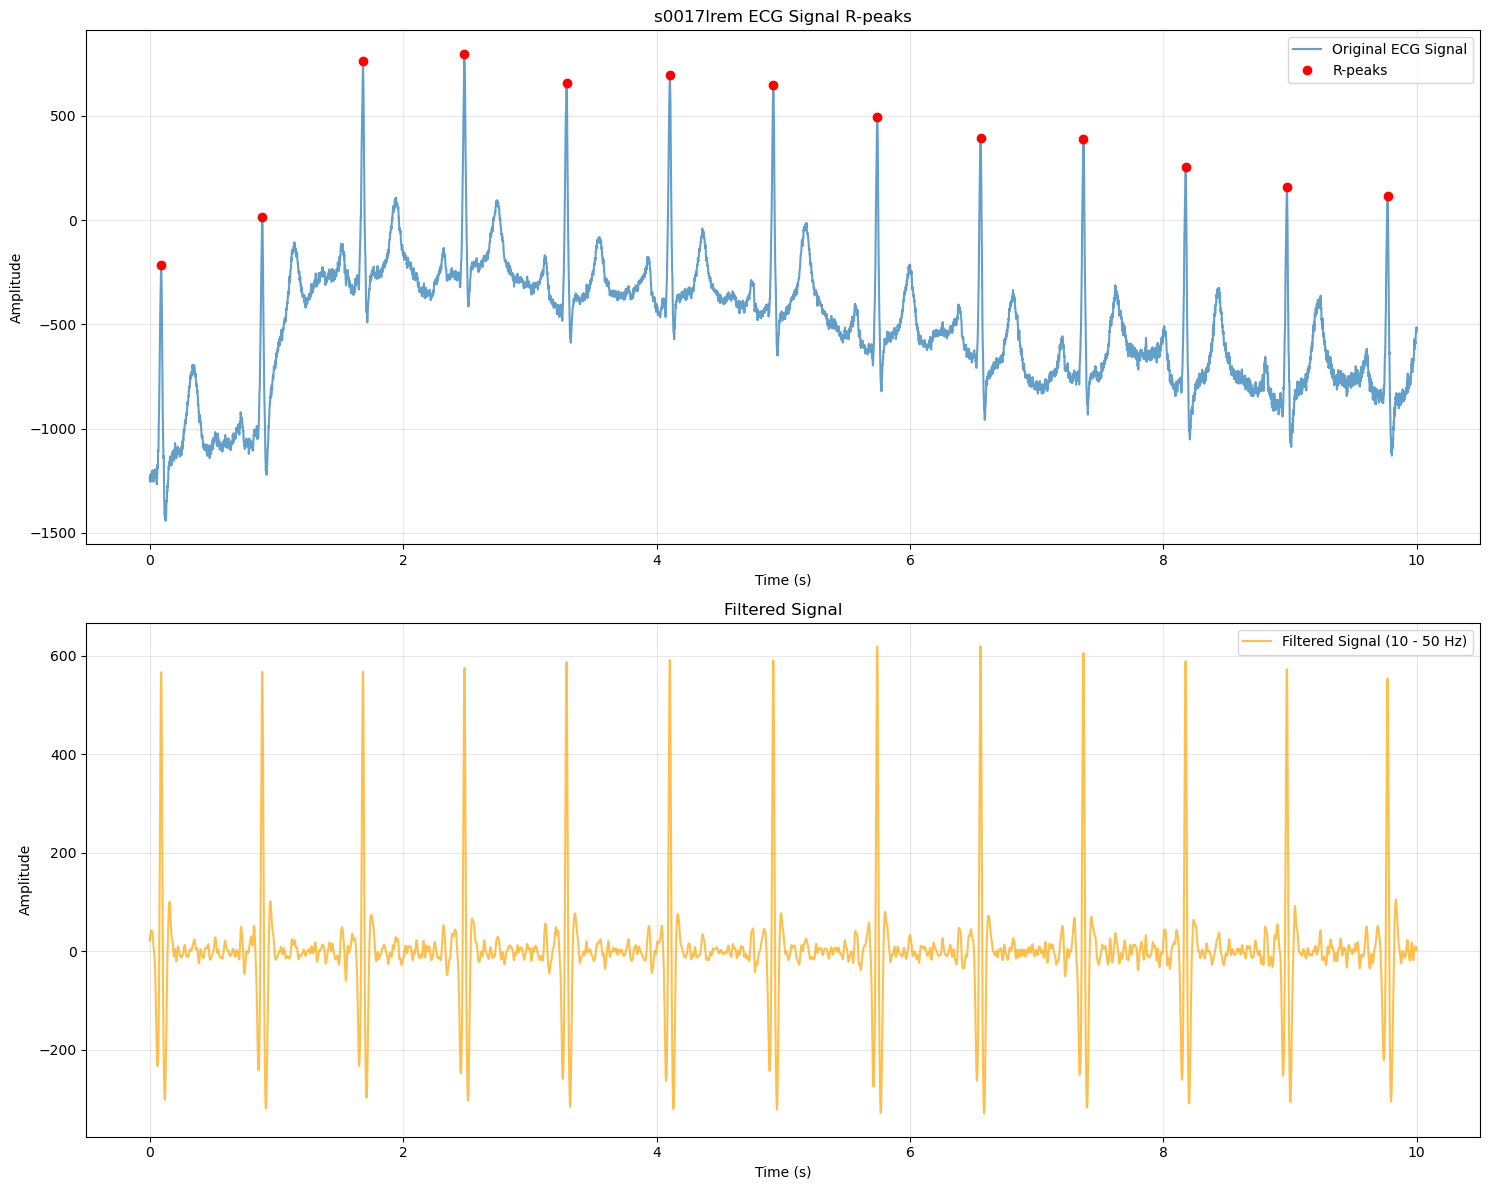

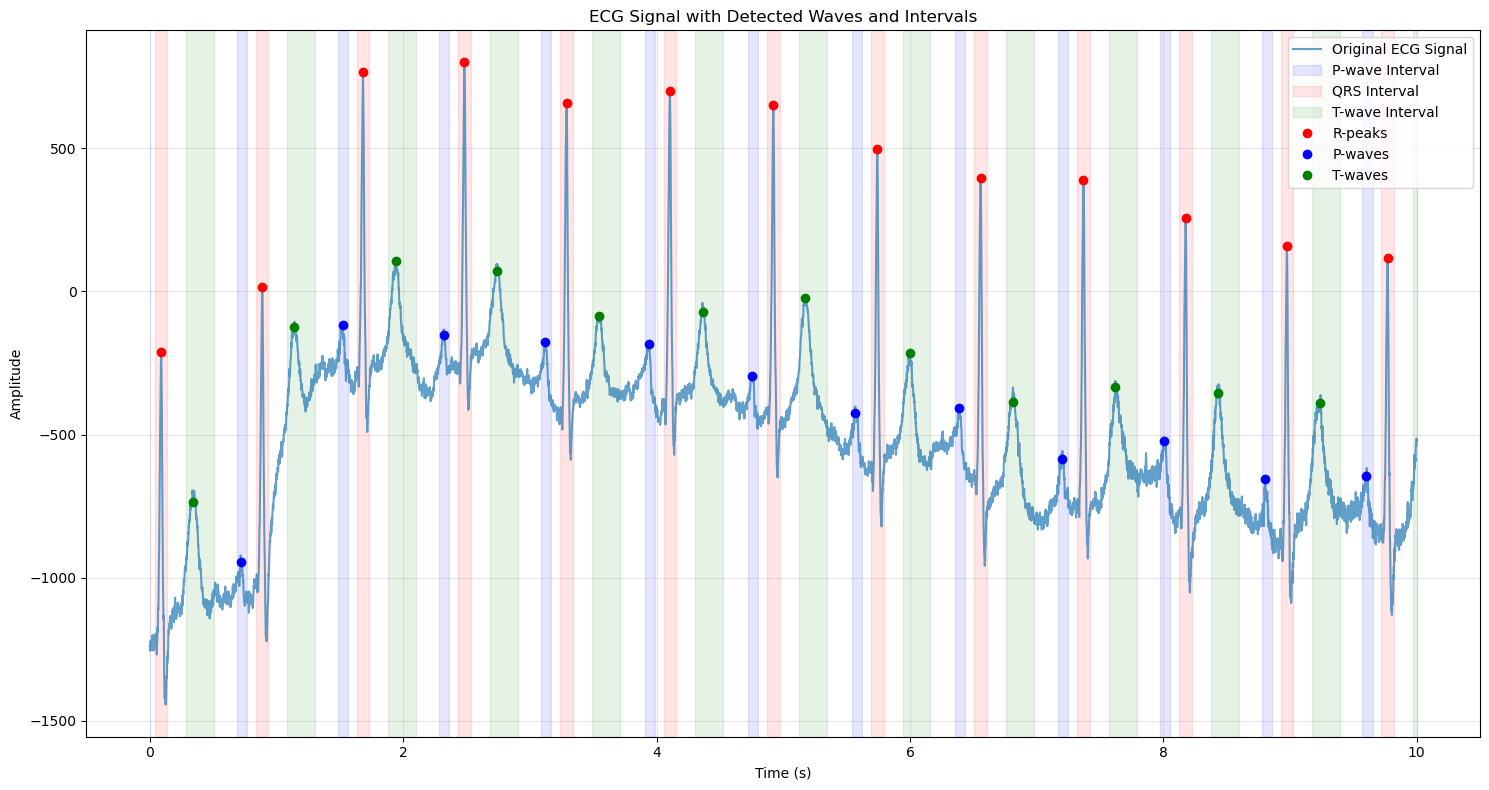

Detected R-peaks at indices: [  90  887 1683 2483 3290 4105 4922 5742 6558 7369 8176 8975 9771]
Detected P-wave locations: [ 722 1522 2322 3122 3938 4754 5570 6386 7201 8003 8804 9601]
Detected T-wave locations: [ 343 1140 1941 2740 3549 4367 5174 6001 6817 7621 8433 9233]


In [110]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.io import loadmat

def bandpass_filter(signal, fs, low_cut=10, high_cut=50):

    nyquist = fs / 2
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(2, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def detect_r_peaks(filtered_signal, original_signal, fs=1000):
    
    # Detect peaks in the QRS band
    min_rr = int(0.4 * fs)  # Minimum R-R interval (400ms)
    min_height = 400        # Minimum peak height
    peaks, _ = find_peaks(filtered_signal, height=min_height, distance=min_rr)
    # Refine peaks to locate precise R positions on the original signal
    refined_peaks = []
    search_window = int(0.05 * fs)  # +/-50ms window for refinement
    for peak in peaks:
        start = max(0, peak - search_window)
        end = min(len(original_signal), peak + search_window)
        refined_peak = start + np.argmax(original_signal[start:end])
        refined_peaks.append(refined_peak)
    print(peaks)
    print(refined_peaks)
    return np.array(refined_peaks), filtered_signal

def detect_p_t_waves(signal, qrs_locs, fs):
    p_waves = []
    t_waves = []
    
    # Wavelet decomposition optimized for P and T waves
    coeffs = pywt.wavedec(signal, 'sym4', level=4)
    low_freq_signal = pywt.waverec([coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]], wavelet="sym4")
    # Use approximation coefficients for smoother signal
    smooth_signal = low_freq_signal
    smooth_signal = np.interp(np.linspace(0, len(smooth_signal), len(signal)), 
                            np.arange(len(smooth_signal)), 
                            smooth_signal)
    
    # Time windows based on physiology
    pr_interval = int(0.2 * fs)  # 200ms
    pr_min = int(0.12 * fs)      # 120ms
    qt_interval = int(0.42 * fs)  # 420ms
    qt_min = int(0.2 * fs)       # 200ms
    
    for qrs in qrs_locs:
        # P wave detection
        p_start = max(0, qrs - pr_interval)
        p_end = max(0, qrs - pr_min)
        
        if p_start < p_end:
            p_window = smooth_signal[p_start:p_end]
            if len(p_window) > 0:
                # Find local maxima in P wave window
                p_peaks, _ = find_peaks(p_window, distance=int(0.1 * fs))
                if len(p_peaks) > 0:
                    p_loc = p_start + p_peaks[np.argmax(p_window[p_peaks])]
                    if p_loc not in p_waves:
                        p_waves.append(p_loc)
        
        # T wave detection
        t_start = min(len(signal)-1, qrs + qt_min)
        t_end = min(len(signal)-1, qrs + qt_interval)
        
        if t_start < t_end:
            t_window = smooth_signal[t_start:t_end]
            if len(t_window) > 0:
                # Find local maxima in T wave window
                t_peaks, _ = find_peaks(t_window, distance=int(0.1 * fs))
                if len(t_peaks) > 0:
                    t_loc = t_start + t_peaks[np.argmax(t_window[t_peaks])]
                    if t_loc not in t_waves:
                        t_waves.append(t_loc)
    
    return np.array(p_waves), np.array(t_waves)

def plot_results(original_signal, filtered_signal, r_peaks, p_waves, t_waves, fs):
    time = np.arange(len(original_signal)) / fs  # Time in seconds

    plt.figure(figsize=(15, 12))

    # Original ECG Signal with R-peaks, P-waves, and T-waves
    plt.subplot(211)
    plt.plot(time, original_signal, label='Original ECG Signal', alpha=0.7)
    plt.plot(r_peaks / fs, original_signal[r_peaks], 'ro', label='R-peaks', markersize=6)
    #plt.plot(p_waves / fs, original_signal[p_waves], 'bo', label='P-waves', markersize=6)
    #plt.plot(t_waves / fs, original_signal[t_waves], 'go', label='T-waves', markersize=6)
    plt.title('s0017lrem ECG Signal R-peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Filtered Signal
    plt.subplot(212)
    plt.plot(time, filtered_signal, label='Filtered Signal (10 - 50 Hz)', color='orange', alpha=0.7)
    plt.title('Filtered Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)


    plt.tight_layout()
    plt.show()

def plot_results_with_intervals(original_signal, filtered_signal, r_peaks, p_waves, t_waves, fs):
    time = np.arange(len(original_signal)) / fs  # Time in seconds

    plt.figure(figsize=(15, 8))

    # Plot Original ECG Signal
    plt.plot(time, original_signal, label='Original ECG Signal', alpha=0.7)
    
    # Overlay intervals for P-wave, QRS complex, and T-wave
    pr_interval = int(0.2 * fs)  # 200ms
    pr_min = int(0.12 * fs)      # 120ms
    qt_interval = int(0.42 * fs)  # 420ms
    qt_min = int(0.2 * fs)       # 200ms

    for qrs in r_peaks:
        # P-wave interval
        p_start = max(0, qrs - pr_interval) / fs
        p_end = max(0, qrs - pr_min) / fs
        plt.axvspan(p_start, p_end, color='blue', alpha=0.1, label='P-wave Interval' if qrs == r_peaks[0] else "")

        # QRS interval (for visualization, +/-50 ms around R-peak)
        qrs_start = max(0, qrs - int(0.05 * fs)) / fs
        qrs_end = min(len(original_signal), qrs + int(0.05 * fs)) / fs
        plt.axvspan(qrs_start, qrs_end, color='red', alpha=0.1, label='QRS Interval' if qrs == r_peaks[0] else "")

        # T-wave interval
        t_start = min(len(original_signal) - 1, qrs + qt_min) / fs
        t_end = min(len(original_signal) - 1, qrs + qt_interval) / fs
        plt.axvspan(t_start, t_end, color='green', alpha=0.1, label='T-wave Interval' if qrs == r_peaks[0] else "")

    # Plot R-peaks, P-waves, and T-waves
    plt.plot(r_peaks / fs, original_signal[r_peaks], 'ro', label='R-peaks', markersize=6)
    plt.plot(p_waves / fs, original_signal[p_waves], 'bo', label='P-waves', markersize=6)
    plt.plot(t_waves / fs, original_signal[t_waves], 'go', label='T-waves', markersize=6)

    plt.title('ECG Signal with Detected Waves and Intervals')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def main():
    mat_data = loadmat('s0017lrem.mat')
    fs = 1000
    ecg_signal = mat_data['val'][0].squeeze()

    # Preprocess signal: Bandpass filter (10 - 50 Hz)
    filtered_signal = bandpass_filter(ecg_signal, fs)

    # Detect R-peaks on the filtered signal
    r_peaks, filtered_signal = detect_r_peaks(filtered_signal, ecg_signal, fs=fs)

    # Detect P and T waves using R-peak locations
    p_waves, t_waves = detect_p_t_waves(ecg_signal, r_peaks, fs)

    # Plot results
    plot_results(ecg_signal, filtered_signal, r_peaks, p_waves, t_waves, fs)
    plot_results_with_intervals(ecg_signal, filtered_signal, r_peaks, p_waves, t_waves, fs)

    print("Detected R-peaks at indices:", r_peaks)
    print("Detected P-wave locations:", p_waves)
    print("Detected T-wave locations:", t_waves)

if __name__ == '__main__':
    main()

### QRS finding for 08378m

[  98  298  499  902 1101 1298 1497 1695 1894 2094 2298]
[97, 298, 499, 902, 1100, 1297, 1497, 1694, 1894, 2094, 2297]


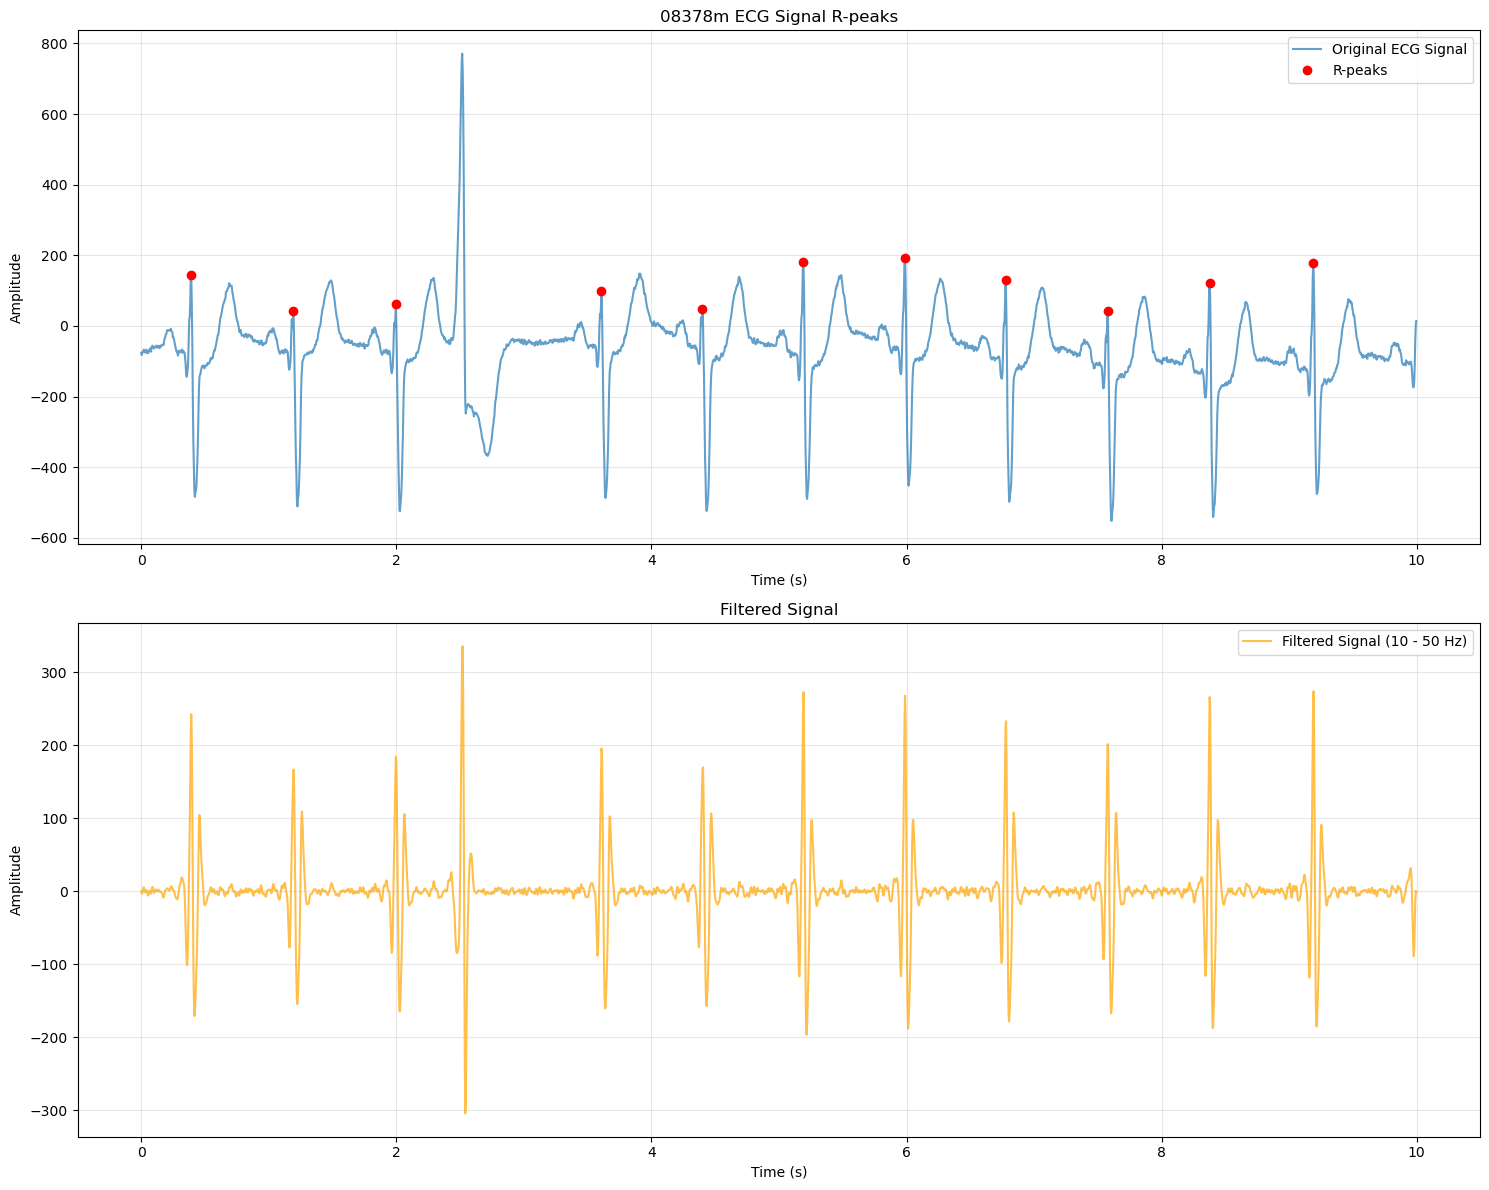

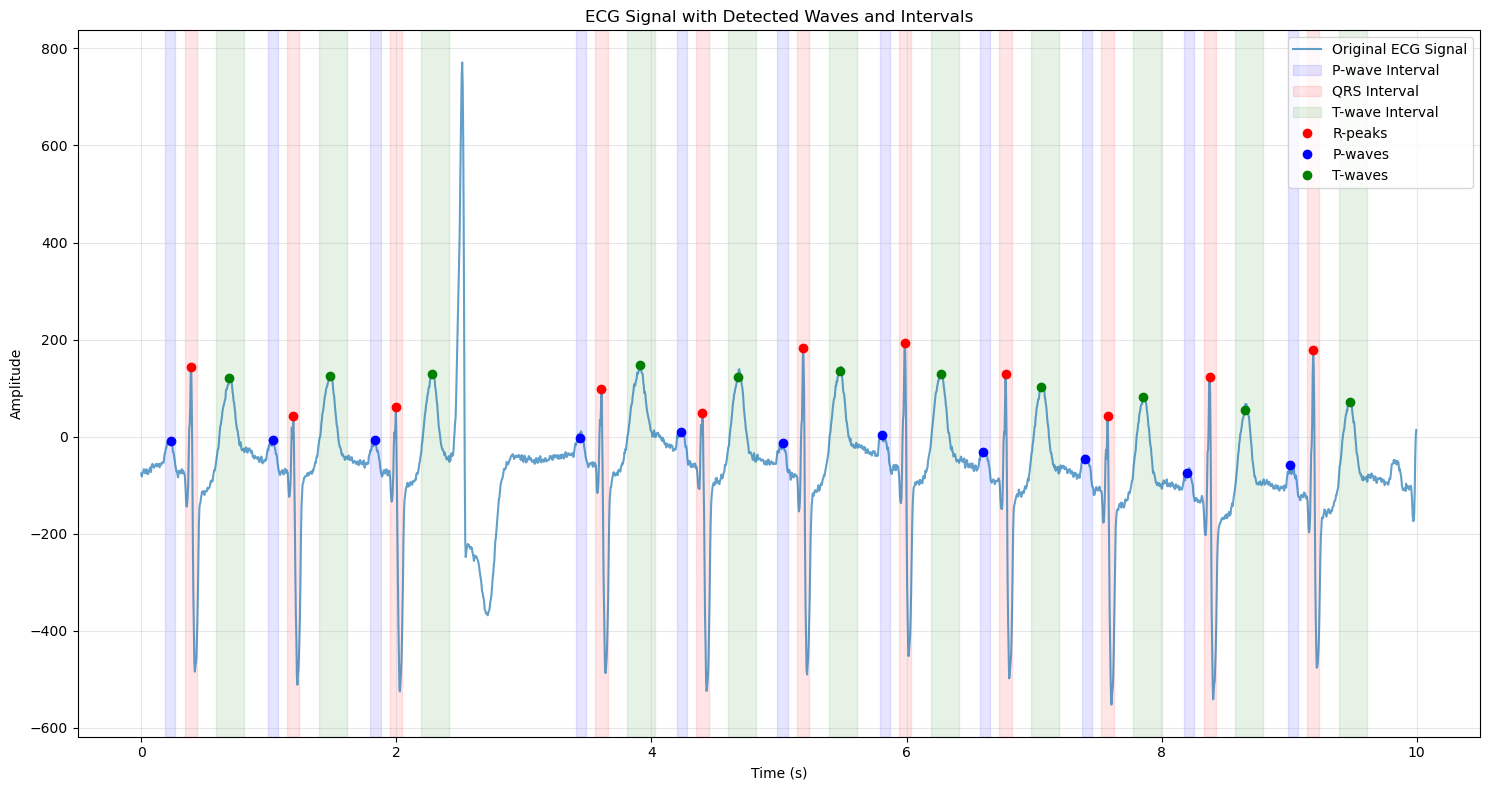

Detected R-peaks at indices: [  97  298  499  902 1100 1297 1497 1694 1894 2094 2297]
Detected P-wave locations: [  58  258  458  859 1058 1257 1452 1650 1850 2050 2251]
Detected T-wave locations: [ 172  370  570  978 1170 1369 1568 1763 1963 2163 2369]


In [109]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.io import loadmat

def bandpass_filter(signal, fs, low_cut=10, high_cut=50):

    nyquist = fs / 2
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(2, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def detect_r_peaks(filtered_signal, original_signal, fs=250):

    # Detect peaks in the QRS band
    min_rr = int(0.4 * fs)  # Minimum R-R interval (400ms)
    min_height = 110        # Minimum peak height
    max_height = 300
    peaks, _ = find_peaks(filtered_signal, height=(min_height, max_height), distance=min_rr)
    # Refine peaks to locate precise R positions on the original signal
    refined_peaks = []
    search_window = int(0.05 * fs)  # +/-50ms window for refinement
    for peak in peaks:
        start = max(0, peak - search_window)
        end = min(len(original_signal), peak + search_window)
        refined_peak = start + np.argmax(original_signal[start:end])
        refined_peaks.append(refined_peak)
    print(peaks)
    print(refined_peaks)
    return np.array(refined_peaks), filtered_signal

def detect_p_t_waves(signal, qrs_locs, fs):
    p_waves = []
    t_waves = []
    
    # Wavelet decomposition optimized for P and T waves
    coeffs = pywt.wavedec(signal, 'sym4', level=3)
    low_freq_signal = pywt.waverec([coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]], wavelet="sym4")
    # Use approximation coefficients for smoother signal
    smooth_signal = low_freq_signal
    smooth_signal = np.interp(np.linspace(0, len(smooth_signal), len(signal)), 
                            np.arange(len(smooth_signal)), 
                            smooth_signal)
    
    # Time windows based on physiology
    pr_interval = int(0.2 * fs)  # 200ms
    pr_min = int(0.12 * fs)      # 120ms
    qt_interval = int(0.42 * fs)  # 420ms
    qt_min = int(0.2 * fs)       # 200ms
    
    for qrs in qrs_locs:
        # P wave detection
        p_start = max(0, qrs - pr_interval)
        p_end = max(0, qrs - pr_min)
        
        if p_start < p_end:
            p_window = smooth_signal[p_start:p_end]
            if len(p_window) > 0:
                # Find local maxima in P wave window
                p_peaks, _ = find_peaks(p_window, distance=int(0.1 * fs))
                if len(p_peaks) > 0:
                    p_loc = p_start + p_peaks[np.argmax(p_window[p_peaks])]
                    if p_loc not in p_waves:
                        p_waves.append(p_loc)
        
        # T wave detection
        t_start = min(len(signal)-1, qrs + qt_min)
        t_end = min(len(signal)-1, qrs + qt_interval)
        
        if t_start < t_end:
            t_window = smooth_signal[t_start:t_end]
            if len(t_window) > 0:
                # Find local maxima in T wave window
                t_peaks, _ = find_peaks(t_window, distance=int(0.1 * fs))
                if len(t_peaks) > 0:
                    t_loc = t_start + t_peaks[np.argmax(t_window[t_peaks])]
                    if t_loc not in t_waves:
                        t_waves.append(t_loc)
    
    return np.array(p_waves), np.array(t_waves)

def plot_results(original_signal, filtered_signal, r_peaks, p_waves, t_waves, fs):
    time = np.arange(len(original_signal)) / fs  # Time in seconds

    plt.figure(figsize=(15, 12))

    # Original ECG Signal with R-peaks, P-waves, and T-waves
    plt.subplot(211)
    plt.plot(time, original_signal, label='Original ECG Signal', alpha=0.7)
    plt.plot(r_peaks / fs, original_signal[r_peaks], 'ro', label='R-peaks', markersize=6)
    #plt.plot(p_waves / fs, original_signal[p_waves], 'bo', label='P-waves', markersize=6)
    #plt.plot(t_waves / fs, original_signal[t_waves], 'go', label='T-waves', markersize=6)
    plt.title('08378m ECG Signal R-peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Filtered Signal
    plt.subplot(212)
    plt.plot(time, filtered_signal, label='Filtered Signal (10 - 50 Hz)', color='orange', alpha=0.7)
    plt.title('Filtered Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)


    plt.tight_layout()
    plt.show()

def plot_results_with_intervals(original_signal, filtered_signal, r_peaks, p_waves, t_waves, fs):
    time = np.arange(len(original_signal)) / fs  # Time in seconds

    plt.figure(figsize=(15, 8))

    # Plot Original ECG Signal
    plt.plot(time, original_signal, label='Original ECG Signal', alpha=0.7)
    
    # Overlay intervals for P-wave, QRS complex, and T-wave
    pr_interval = int(0.2 * fs)  # 200ms
    pr_min = int(0.12 * fs)      # 120ms
    qt_interval = int(0.42 * fs)  # 420ms
    qt_min = int(0.2 * fs)       # 200ms

    for qrs in r_peaks:
        # P-wave interval
        p_start = max(0, qrs - pr_interval) / fs
        p_end = max(0, qrs - pr_min) / fs
        plt.axvspan(p_start, p_end, color='blue', alpha=0.1, label='P-wave Interval' if qrs == r_peaks[0] else "")

        # QRS interval (for visualization, +/-50 ms around R-peak)
        qrs_start = max(0, qrs - int(0.05 * fs)) / fs
        qrs_end = min(len(original_signal), qrs + int(0.05 * fs)) / fs
        plt.axvspan(qrs_start, qrs_end, color='red', alpha=0.1, label='QRS Interval' if qrs == r_peaks[0] else "")

        # T-wave interval
        t_start = min(len(original_signal) - 1, qrs + qt_min) / fs
        t_end = min(len(original_signal) - 1, qrs + qt_interval) / fs
        plt.axvspan(t_start, t_end, color='green', alpha=0.1, label='T-wave Interval' if qrs == r_peaks[0] else "")

    # Plot R-peaks, P-waves, and T-waves
    plt.plot(r_peaks / fs, original_signal[r_peaks], 'ro', label='R-peaks', markersize=6)
    plt.plot(p_waves / fs, original_signal[p_waves], 'bo', label='P-waves', markersize=6)
    plt.plot(t_waves / fs, original_signal[t_waves], 'go', label='T-waves', markersize=6)

    plt.title('ECG Signal with Detected Waves and Intervals')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def main():
    mat_data = loadmat('08378m.mat')
    fs = 250
    ecg_signal = mat_data['val'][0].squeeze()

    # Preprocess signal: Bandpass filter (10 - 50 Hz)
    filtered_signal = bandpass_filter(ecg_signal, fs)

    # Detect R-peaks on the filtered signal
    r_peaks, filtered_signal = detect_r_peaks(filtered_signal, ecg_signal, fs=fs)

    # Detect P and T waves using R-peak locations
    p_waves, t_waves = detect_p_t_waves(ecg_signal, r_peaks, fs)

    # Plot results
    plot_results(ecg_signal, filtered_signal, r_peaks, p_waves, t_waves, fs)
    plot_results_with_intervals(ecg_signal, filtered_signal, r_peaks, p_waves, t_waves, fs)

    print("Detected R-peaks at indices:", r_peaks)
    print("Detected P-wave locations:", p_waves)
    print("Detected T-wave locations:", t_waves)

if __name__ == '__main__':
    main()

## wavelets

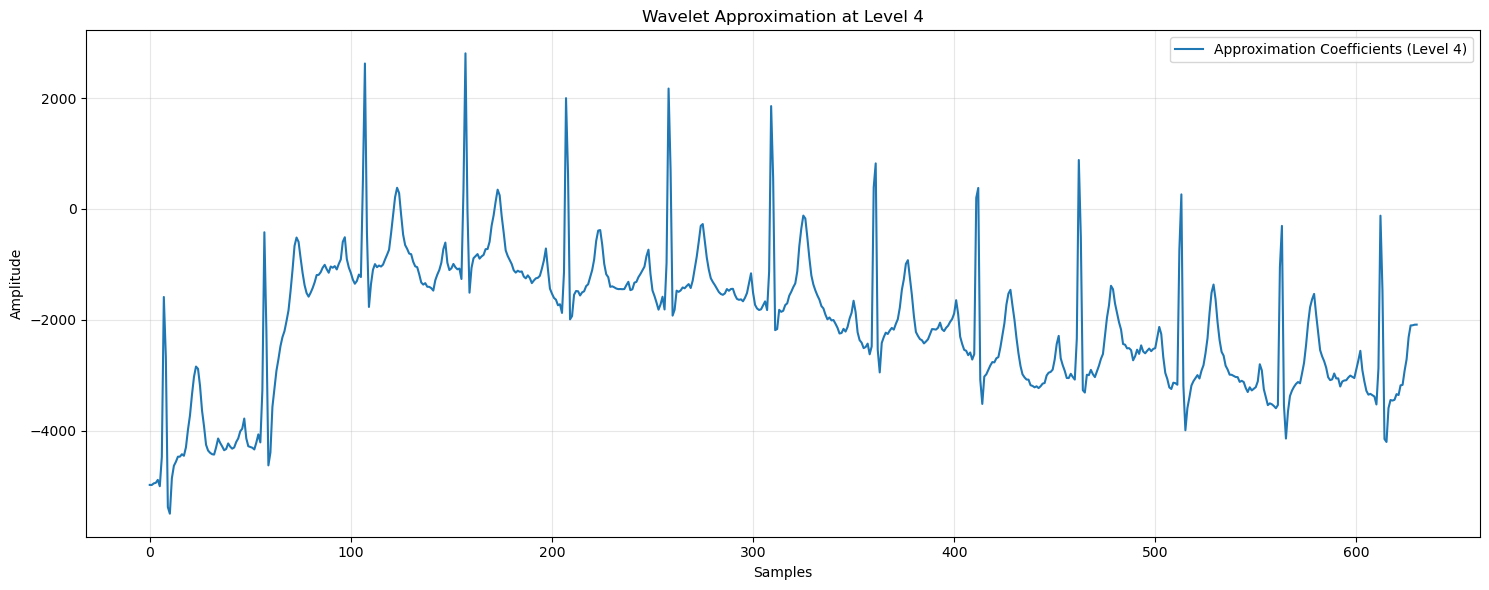

In [11]:
def plot_wavelet_level_3(signal, fs):
    # Perform the wavelet transform at level 3
    coeffs = pywt.wavedec(signal, 'sym4', level=4)
    
    # Plot only the approximation coefficients at level 4
    plt.figure(figsize=(15, 6))
    plt.plot(coeffs[0], label="Approximation Coefficients (Level 4)")
    plt.title("Wavelet Approximation at Level 4")
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Load ECG data from a .mat file
mat_data = loadmat('s0017lrem.mat')
fs = 1000 # Sampling frequency
ecg_signal = mat_data['val'][0].squeeze()
# Plot the wavelet transform of the ECG signal
plot_wavelet_level_3(ecg_signal, fs)

### fast and slow components example

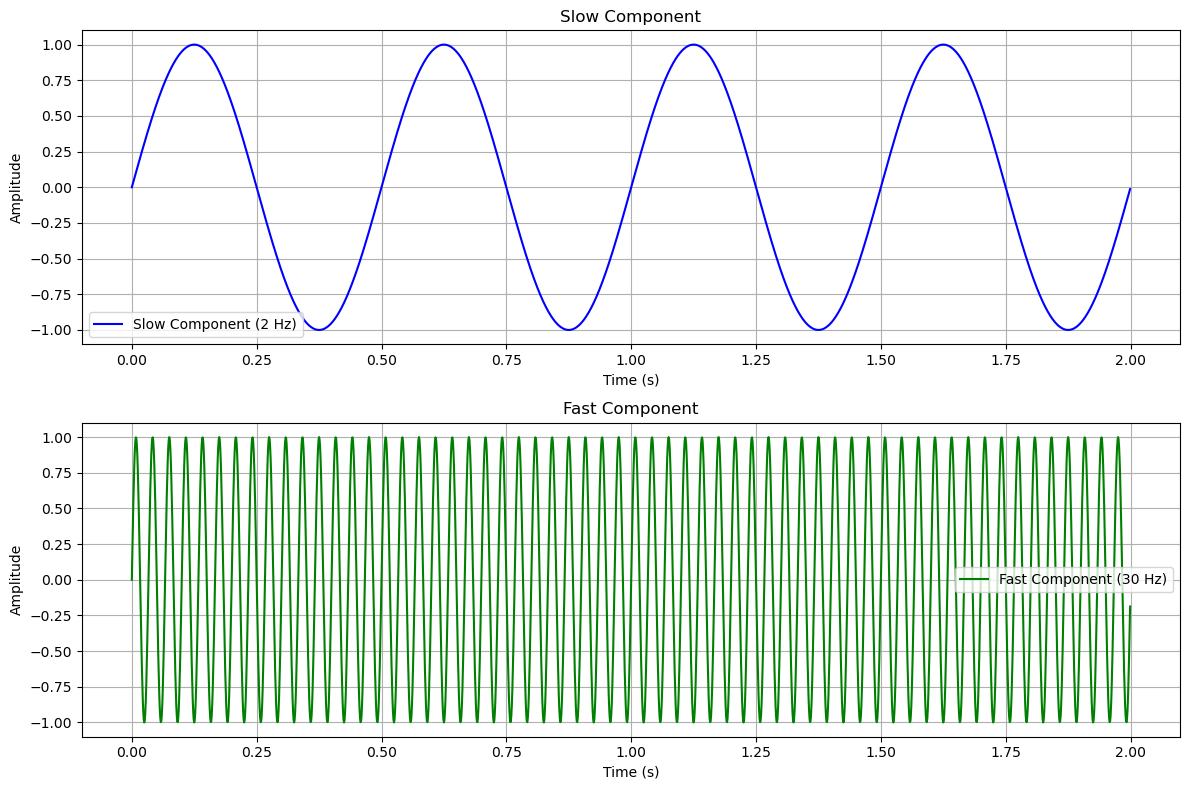

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Generate time axis
fs = 1000  # Sampling frequency (Hz)
duration = 2  # Duration of signal (seconds)
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Create a fast component (high-frequency sine wave)
fast_component = np.sin(2 * np.pi * 30 * t)  # 30 Hz sine wave

# Create a slow component (low-frequency sine wave)
slow_component = np.sin(2 * np.pi * 2 * t)  # 2 Hz sine wave

# Combine fast and slow components
combined_signal = fast_component + slow_component

# Plot the components and combined signal
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t, slow_component, label="Slow Component (2 Hz)", color="blue")
plt.title("Slow Component")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, fast_component, label="Fast Component (30 Hz)", color="green")
plt.title("Fast Component")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()



plt.tight_layout()
plt.show()